In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date

# CLTV

Customer Lifetime Value (CLV / CLTV) is a metric that allows a business to see how much revenue a customer might bring in over time.

**Lifetime Value: Total Gross Revenue - Total Aquision Cost**

**IDEA**

1. WE WILL USE SAME DATASET THAT WE USED FOR CUSTOMER SEGMENTATION.
2. DIVIDE THE DATA INTO 3 MONTH AND 6 MONTH
3. WE WILL CALCULATE R-F-M VALUES FOR 3 MONTH DATA THEN CALCULATE REVENUE FOR 6 MONTHS(THIS WILL BE USED TO CALCULATE LTV ). 
4. WE WILL USE ML MODELLING TO DETERMINE THE SEGMENT, SEGMENT(BUCKET) WHERE THE CUSTOMER FALLS.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/Data/Sales Forecasting/data.csv",encoding='unicode_escape')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [6]:
data_uk = df.query("Country=='United Kingdom'")
data_uk.shape

(495478, 8)

In [8]:
data_uk.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 34.0+ MB


In [9]:
#CONVERTING DATE TO DATETIME FORMAT
data_uk['InvoiceDate'] = pd.to_datetime(data_uk['InvoiceDate'])

<ipython-input-9-403e7b1f7d3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_uk['InvoiceDate'] = pd.to_datetime(data_uk['InvoiceDate'])


In [18]:
start_date_3_month = pd.to_datetime('2011-03-01')
end_date_3_month = pd.to_datetime('2011-06-01')

start_date_6_month = pd.to_datetime('2011-06-01')
end_date_6_month = pd.to_datetime('2011-12-01')

tx_3m = data_uk[(data_uk.InvoiceDate < end_date_3_month) & (data_uk.InvoiceDate >= start_date_3_month)].reset_index(drop=True)
tx_6m = data_uk[(data_uk.InvoiceDate >= start_date_6_month) & (data_uk.InvoiceDate < end_date_6_month)].reset_index(drop=True)


**CALCULATING R-F-M FOR THESE 3 MONTHS CUSTOMER**

In [20]:
from sklearn.cluster import KMeans

#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

#*************ORDER CLUSTER **************************#
def order_cluster(cluster_field_name, target_field_name,df,ascending):
  df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
  df_new['index'] = df_new.index
  df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
  df_final = df_final.drop([cluster_field_name],axis=1)
  df_final = df_final.rename(columns={"index":cluster_field_name})
  return df_final


#*************RECENCY SCORE**************************#
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#*************FREQUENCY SCORE**************************#
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#*************REVENUE SCORE**************************#
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)


#overall scoring
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
tx_user.head(5)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


**There is no cost specified in the dataset. That’s why Revenue becomes our LTV or Lifetime Monetary Value or the Lifetime spend by a Customer directly.**

In [23]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']
tx_user_6m

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98
...,...,...
3162,18278.0,173.90
3163,18281.0,80.82
3164,18282.0,98.76
3165,18283.0,1351.83


**OUTLIARS PRESENT**

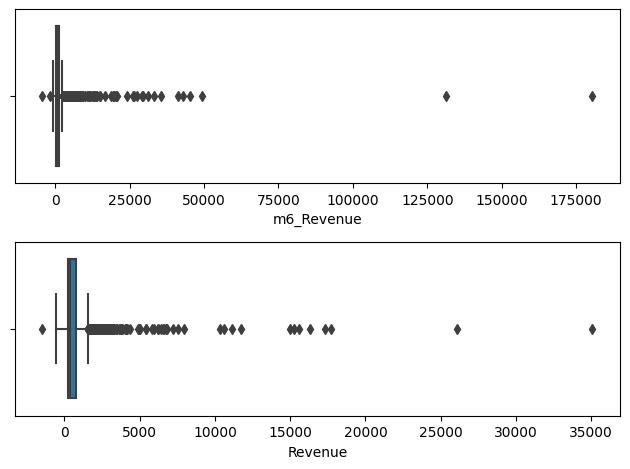

In [40]:
fig, ax = plt.subplots(2)
sns.boxplot(ax=ax[0],data =tx_user_6m,x='m6_Revenue')
sns.boxplot(ax=ax[1],data =tx_user,x='Revenue')
fig.tight_layout()

In [41]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')
tx_merge = tx_merge.fillna(0)

tx_graph = tx_merge.query("m6_Revenue < 30000")
tx_graph

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04
...,...,...,...,...,...,...,...,...,...,...
1832,16422.0,4,3,129,1,10348.13,2,6,High-Value,16756.31
1834,13798.0,4,3,122,1,11105.20,2,6,High-Value,12913.99
1837,15311.0,4,3,522,2,16309.61,2,7,High-Value,29313.15
1838,13089.0,5,3,452,2,11757.87,2,7,High-Value,26013.37


<Axes: xlabel='OverallScore', ylabel='m6_Revenue'>

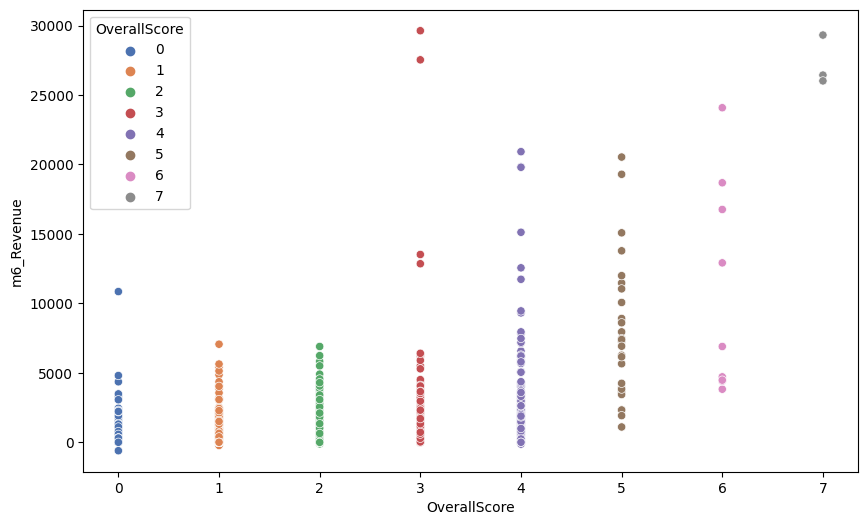

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(ax=ax, data=tx_graph, x="OverallScore", y="m6_Revenue",hue='OverallScore',palette="deep")

In [ ]:
#RUN AND DEBUG
tx_merge['m6_Revenue'].describe()
tx_merge['m6_Revenue'].quantile(0.99)
tx_merge['m6_Revenue'].quantile(0.75)

In [49]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [50]:
tx_merge['m6_Revenue'].describe()

count     1821.000000
mean      1063.979051
std       1707.958413
min       -609.400000
25%          0.000000
50%        505.230000
75%       1344.600000
max      16756.310000
Name: m6_Revenue, dtype: float64

In [51]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1397.0,398.393172,422.252144,-609.40,0.0000,298.000,687.7200,1448.78
1,368.0,2501.323098,936.361335,1464.05,1739.9875,2165.315,3054.7925,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.4350,6986.545,9607.3225,16756.31


In [52]:
tx_cluster

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0
...,...,...,...,...,...,...,...,...,...,...,...
1816,16180.0,18,2,78,1,2745.43,1,4,Mid-Value,7472.05,2
1817,15039.0,6,3,436,2,6741.59,1,6,High-Value,6893.23,2
1818,16333.0,0,3,29,0,10578.72,2,5,High-Value,11992.40,2
1819,16422.0,4,3,129,1,10348.13,2,6,High-Value,16756.31,2


In [55]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

In [60]:
#calculate and show correlations
corr_matrix = tx_class.corr()
#corr_matrix.style.background_gradient(cmap='coolwarm')
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.846486
Revenue               0.600919
RevenueCluster        0.468524
OverallScore          0.374182
FrequencyCluster      0.364976
Frequency             0.359304
Segment_High-Value    0.353371
RecencyCluster        0.238332
Segment_Mid-Value     0.168752
CustomerID           -0.027701
Recency              -0.239131
Segment_Low-Value    -0.266561
Name: LTVCluster, dtype: float64

In [108]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#create X and y, X will be feature set and y is the label - LTV
#REMOVING 'm6_Revenue' BECAUSE THIS ONE IS HIGHLY CO-RELATED

X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=56)

In [109]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [110]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=0, warm_start=False)

In [111]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred = classifier_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       140
           1       0.71      0.29      0.41        35
           2       0.71      0.62      0.67         8

    accuracy                           0.83       183
   macro avg       0.76      0.63      0.66       183
weighted avg       0.81      0.83      0.80       183



# FINE TUNE MODE
GRID SEARCH CV : GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid.

In [112]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [113]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [114]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [115]:
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       140
           1       0.69      0.26      0.37        35
           2       0.80      0.50      0.62         8

    accuracy                           0.82       183
   macro avg       0.77      0.58      0.63       183
weighted avg       0.80      0.82      0.79       183



In [116]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
5,Revenue,0.368236
7,OverallScore,0.206877
3,Frequency,0.160249
6,RevenueCluster,0.083282
4,FrequencyCluster,0.073214
8,Segment_High-Value,0.044808
1,Recency,0.028272
9,Segment_Low-Value,0.014918
0,CustomerID,0.011660
10,Segment_Mid-Value,0.008483


** YOU CAN CLEARLY SEE THE DIFFERENCE BETWEEN OUR INITIAL MODEL ILE. THE RANDOM FOREST AND THE MODEL AFTER FINE TUNING. AS WE OBSERVED BOTH OF THE CLASSIFICATION REPORTS, THE PRECISION HAS INCREASED ⚓**

**Precision and recall are acceptable for 0. As an example, for cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision). And the model successfully identifies 93% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 70% of Mid LTV customers. **

**LETS TRY TO APPLY OTHER MODELS AS WELL**

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Assume you have your feature matrix X and target variable y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

#ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)


# Initialize the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XG Boost Classifier': xgb.XGBClassifier()
}

# Iterate over the classifiers and fit the models
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = classifier.predict(X_test)
    print("Algorithm:-",name)
    print(classification_report(y_test, y_pred))
    print('**************************************')

Algorithm:- Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        71
           1       0.55      0.32      0.40        19
           2       0.25      0.50      0.33         2

    accuracy                           0.79        92
   macro avg       0.55      0.58      0.54        92
weighted avg       0.78      0.79      0.78        92

**************************************
Algorithm:- Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        71
           1       0.30      0.32      0.31        19
           2       0.50      1.00      0.67         2

    accuracy                           0.70        92
   macro avg       0.54      0.70      0.59        92
weighted avg       0.71      0.70      0.70        92

**************************************
Algorithm:- Random Forest
              precision    recall  f1-score   support

           0       0.

In [ ]:
# !pip install pycaret

In [68]:
# import pycaret

In [73]:
# temp = tx_class.copy()
# del temp['m6_Revenue']

In [78]:
# # init setup
# from pycaret.classification import *
# s = setup(data = temp, target = 'LTVCluster', session_id=123)

In [77]:
# best_model = compare_models()